In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms
import os

import matplotlib.pyplot as plt
import numpy as np

In [6]:
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'

In [7]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding =4), #cifar 10 image size : 32x32
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.CIFAR10(root = './data', train=True, 
                download= True, transform = transform_train)
test_dataset = torchvision.datasets.CIFAR10(root = './data', train = False,
                download=True, transform= transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=96,
                                          shuffle = True, num_workers = 2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=96,
                                         shuffle =True, num_workers =2)

#num_workers =2 인지 4인지 or batch_size test의 경우는 왜 100인지?

Files already downloaded and verified
Files already downloaded and verified


In [8]:
class Block(nn.Module):
    '''expand + depthwise + pointwise'''
    def __init__(self, in_planes, out_planes, expansion, stride):
        super(Block, self).__init__()
        self.stride = stride

        planes = expansion * in_planes
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, groups=planes, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(out_planes)

        self.shortcut = nn.Sequential()
        if stride == 1 and in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(out_planes),
            )

    def forward(self, x):
        out = F.relu6(self.bn1(self.conv1(x)))
        out = F.relu6(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out = out + self.shortcut(x) if self.stride==1 else out
        return out

In [9]:
class MobileNetV2(nn.Module):
    # (expansion, out_planes, num_blocks, stride)
    cfg = [(1,  16, 1, 1),
           (6,  24, 2, 1),  # NOTE: change stride 2 -> 1 for CIFAR10
           (6,  32, 3, 2),
           (6,  64, 4, 2),
           (6,  96, 3, 1),
           (6, 160, 3, 2),
           (6, 320, 1, 1)]

    def __init__(self, num_classes=10):
        super(MobileNetV2, self).__init__()
        # NOTE: change conv1 stride 2 -> 1 for CIFAR10
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32)
        self.conv2 = nn.Conv2d(320, 1280, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(1280)
        self.linear = nn.Linear(1280, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for expansion, out_planes, num_blocks, stride in self.cfg:
            strides = [stride] + [1]*(num_blocks-1)
            for stride in strides:
                layers.append(Block(in_planes, out_planes, expansion, stride))
                in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.relu(self.bn2(self.conv2(out)))
        # NOTE: change pooling kernel_size 7 -> 4 for CIFAR10
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


In [10]:
net = MobileNetV2()
net = net.to(device)

if device == 'cuda:1':
#     net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

In [14]:
# net = torch.nn.DataParallel(net)
cudnn.benchmark = True

learning_rate = 0.045
file_name = 'resnet18_cifar10.pt'

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.00004)

loss_list_train = []
accuracy_list_train = []

loss_list_test = []
accuracy_list_test =[]

def train(epoch):
    print('\n[ Train epoch: %d ]' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        benign_outputs = net(inputs)
        loss = criterion(benign_outputs, targets)#예측값과 실제 타깃값
        loss.backward()

        optimizer.step()
        train_loss += loss.item()
        _, predicted = benign_outputs.max(1)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        if batch_idx % 100 == 0:
            print('\nCurrent batch:', str(batch_idx))
            print('Current benign train accuracy:', str(predicted.eq(targets).sum().item() / targets.size(0)))
            print('Current benign train loss:', loss.item())
            
    accuracy_list_train.append(100. * correct / total)
    print('\nTotal benign train accuarcy:', 100. * correct / total)
    loss_list_train.append(train_loss)
    print('Total benign train loss:', train_loss)


def test(epoch):
    print('\n[ Test epoch: %d ]' % epoch)
    net.eval()
    loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        total += targets.size(0)

        outputs = net(inputs)
        loss += criterion(outputs, targets).item()

        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()
        
    accuracy_list_test.append(100. * correct / total)
    print('\nTest accuarcy:', 100. * correct / total)
    loss_list_test.append(loss)
    print('Test average loss:', loss / total)    

    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print('Model Saved!')


        
#learning rate를 바꾸기
def adjust_learning_rate(optimizer, epoch):
    for param_group in optimizer.param_groups:
        lr = param_group['lr']
        if epoch <=200 and epoch != 0:
            param_group['lr'] = lr * 0.98
        print(param_group['lr'])

In [15]:
for epoch in range(0, 200):
    adjust_learning_rate(optimizer, epoch)
    train(epoch)
    test(epoch)

0.045

[ Train epoch: 0 ]

Current batch: 0
Current benign train accuracy: 0.6875
Current benign train loss: 0.8298447728157043

Current batch: 100
Current benign train accuracy: 0.7395833333333334
Current benign train loss: 0.7482714653015137

Current batch: 200
Current benign train accuracy: 0.6770833333333334
Current benign train loss: 0.8170128464698792

Current batch: 300
Current benign train accuracy: 0.71875
Current benign train loss: 0.8346114754676819

Current batch: 400
Current benign train accuracy: 0.75
Current benign train loss: 0.6526117324829102

Current batch: 500
Current benign train accuracy: 0.75
Current benign train loss: 0.7926762700080872

Total benign train accuarcy: 72.68
Total benign train loss: 406.4459456503391

[ Test epoch: 0 ]

Test accuarcy: 73.47
Test average loss: 0.008045633187890052
Model Saved!
0.0441

[ Train epoch: 1 ]

Current batch: 0
Current benign train accuracy: 0.6979166666666666
Current benign train loss: 0.8069179058074951

Current batch: 1


Current batch: 400
Current benign train accuracy: 0.8854166666666666
Current benign train loss: 0.3716002404689789

Current batch: 500
Current benign train accuracy: 0.9166666666666666
Current benign train loss: 0.2418447881937027

Total benign train accuarcy: 87.906
Total benign train loss: 181.63838216662407

[ Test epoch: 9 ]

Test accuarcy: 86.02
Test average loss: 0.004370092949271202
Model Saved!
0.036768276309939604

[ Train epoch: 10 ]

Current batch: 0
Current benign train accuracy: 0.84375
Current benign train loss: 0.4532289206981659

Current batch: 100
Current benign train accuracy: 0.875
Current benign train loss: 0.37808942794799805

Current batch: 200
Current benign train accuracy: 0.8958333333333334
Current benign train loss: 0.34616443514823914

Current batch: 300
Current benign train accuracy: 0.875
Current benign train loss: 0.3418457806110382

Current batch: 400
Current benign train accuracy: 0.8854166666666666
Current benign train loss: 0.432843953371048

Current 


Total benign train accuarcy: 91.656
Total benign train loss: 123.27658575773239

[ Test epoch: 18 ]

Test accuarcy: 88.52
Test average loss: 0.0036174226716160773
Model Saved!
0.030655468090795137

[ Train epoch: 19 ]

Current batch: 0
Current benign train accuracy: 0.9479166666666666
Current benign train loss: 0.1530274897813797

Current batch: 100
Current benign train accuracy: 0.9166666666666666
Current benign train loss: 0.23657108843326569

Current batch: 200
Current benign train accuracy: 0.8854166666666666
Current benign train loss: 0.2309957891702652

Current batch: 300
Current benign train accuracy: 0.9375
Current benign train loss: 0.2082669883966446

Current batch: 400
Current benign train accuracy: 0.9375
Current benign train loss: 0.15552137792110443

Current batch: 500
Current benign train accuracy: 0.9270833333333334
Current benign train loss: 0.19980859756469727

Total benign train accuarcy: 92.202
Total benign train loss: 115.10070978105068

[ Test epoch: 19 ]

Test a


Current batch: 0
Current benign train accuracy: 0.9583333333333334
Current benign train loss: 0.11754635721445084

Current batch: 100
Current benign train accuracy: 0.9166666666666666
Current benign train loss: 0.1751067191362381

Current batch: 200
Current benign train accuracy: 0.9375
Current benign train loss: 0.15933921933174133

Current batch: 300
Current benign train accuracy: 0.9270833333333334
Current benign train loss: 0.14812327921390533

Current batch: 400
Current benign train accuracy: 0.9479166666666666
Current benign train loss: 0.17113476991653442

Current batch: 500
Current benign train accuracy: 0.9583333333333334
Current benign train loss: 0.10770130157470703

Total benign train accuarcy: 94.462
Total benign train loss: 81.85974657908082

[ Test epoch: 28 ]

Test accuarcy: 89.63
Test average loss: 0.003656907065957785
Model Saved!
0.025047749359397607

[ Train epoch: 29 ]

Current batch: 0
Current benign train accuracy: 0.96875
Current benign train loss: 0.0723285079


Current batch: 200
Current benign train accuracy: 0.96875
Current benign train loss: 0.07185401767492294

Current batch: 300
Current benign train accuracy: 0.9583333333333334
Current benign train loss: 0.07718160003423691

Current batch: 400
Current benign train accuracy: 0.96875
Current benign train loss: 0.09954693168401718

Current batch: 500
Current benign train accuracy: 0.9583333333333334
Current benign train loss: 0.08614892512559891

Total benign train accuarcy: 96.044
Total benign train loss: 58.068379713222384

[ Test epoch: 37 ]

Test accuarcy: 89.83
Test average loss: 0.0038194236397743227
Model Saved!
0.020883504974794645

[ Train epoch: 38 ]

Current batch: 0
Current benign train accuracy: 0.9583333333333334
Current benign train loss: 0.11219149827957153

Current batch: 100
Current benign train accuracy: 0.96875
Current benign train loss: 0.13241563737392426

Current batch: 200
Current benign train accuracy: 0.96875
Current benign train loss: 0.14205320179462433

Current


Current batch: 400
Current benign train accuracy: 0.9479166666666666
Current benign train loss: 0.09992796927690506

Current batch: 500
Current benign train accuracy: 0.9791666666666666
Current benign train loss: 0.05750953033566475

Total benign train accuarcy: 97.218
Total benign train loss: 40.79382605012506

[ Test epoch: 46 ]

Test accuarcy: 90.35
Test average loss: 0.003999273750931024
Model Saved!
0.017411575538168883

[ Train epoch: 47 ]

Current batch: 0
Current benign train accuracy: 0.9791666666666666
Current benign train loss: 0.053991418331861496

Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.019899053499102592

Current batch: 200
Current benign train accuracy: 0.96875
Current benign train loss: 0.055744633078575134

Current batch: 300
Current benign train accuracy: 0.9791666666666666
Current benign train loss: 0.052645593881607056

Current batch: 400
Current benign train accuracy: 0.96875
Current benign train loss: 0.07723506540060043


Total benign train accuarcy: 98.014
Total benign train loss: 28.873357660369948

[ Test epoch: 55 ]

Test accuarcy: 91.02
Test average loss: 0.003927735856361687
Model Saved!
0.01451686214010837

[ Train epoch: 56 ]

Current batch: 0
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.0960538312792778

Current batch: 100
Current benign train accuracy: 0.9583333333333334
Current benign train loss: 0.08056589215993881

Current batch: 200
Current benign train accuracy: 0.9791666666666666
Current benign train loss: 0.1280822604894638

Current batch: 300
Current benign train accuracy: 0.9791666666666666
Current benign train loss: 0.07700341939926147

Current batch: 400
Current benign train accuracy: 0.9791666666666666
Current benign train loss: 0.038184236735105515

Current batch: 500
Current benign train accuracy: 0.9791666666666666
Current benign train loss: 0.0450671948492527

Total benign train accuarcy: 98.234
Total benign train loss: 26.579132004408166

[ T


Current batch: 0
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.019078651443123817

Current batch: 100
Current benign train accuracy: 0.9791666666666666
Current benign train loss: 0.030285201966762543

Current batch: 200
Current benign train accuracy: 0.9791666666666666
Current benign train loss: 0.03339023515582085

Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 0.01210864633321762

Current batch: 400
Current benign train accuracy: 0.96875
Current benign train loss: 0.05803341791033745

Current batch: 500
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.029556261375546455

Total benign train accuarcy: 98.702
Total benign train loss: 18.783209654153325

[ Test epoch: 65 ]

Test accuarcy: 91.36
Test average loss: 0.004059321551490575
Model Saved!
0.011861333296017903

[ Train epoch: 66 ]

Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.009209297597408295

Cur


Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 0.004166895058006048

Current batch: 400
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.013849947601556778

Current batch: 500
Current benign train accuracy: 0.9791666666666666
Current benign train loss: 0.027270592749118805

Total benign train accuarcy: 99.094
Total benign train loss: 13.34069703950081

[ Test epoch: 74 ]

Test accuarcy: 91.52
Test average loss: 0.0043190588895231485
Model Saved!
0.009889360091434759

[ Train epoch: 75 ]

Current batch: 0
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.02977309376001358

Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.006455809343606234

Current batch: 200
Current benign train accuracy: 0.9791666666666666
Current benign train loss: 0.10979148745536804

Current batch: 300
Current benign train accuracy: 0.96875
Current benign train loss: 0.04380908980965614

C


Total benign train accuarcy: 99.48
Total benign train loss: 8.32509835838573

[ Test epoch: 83 ]

Test accuarcy: 91.49
Test average loss: 0.004468854109430685
Model Saved!
0.008245231845132941

[ Train epoch: 84 ]

Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.0028590888250619173

Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.01731082797050476

Current batch: 200
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.022464493289589882

Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 0.006251261103898287

Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.010854070074856281

Current batch: 500
Current benign train accuracy: 1.0
Current benign train loss: 0.007763501722365618

Total benign train accuarcy: 99.464
Total benign train loss: 8.282652291440172

[ Test epoch: 84 ]

Test accuarcy: 91.76
Test average loss: 0.00430486193


Current batch: 300
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.03343485668301582

Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.008372699841856956

Current batch: 500
Current benign train accuracy: 1.0
Current benign train loss: 0.0006296540377661586

Total benign train accuarcy: 99.684
Total benign train loss: 5.189482127796509

[ Test epoch: 93 ]

Test accuarcy: 91.8
Test average loss: 0.004568839876540005
Model Saved!
0.006736954727141358

[ Train epoch: 94 ]

Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.0012688451679423451

Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.006772767752408981

Current batch: 200
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.019350344315171242

Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 0.00811903364956379

Current batch: 400
Current benign 


Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.010590418241918087

Current batch: 100
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.014035115949809551

Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.00184280623216182

Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 0.002205998869612813

Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.001928286044858396

Current batch: 500
Current benign train accuracy: 1.0
Current benign train loss: 0.002752402564510703

Total benign train accuarcy: 99.754
Total benign train loss: 3.9717121347784996

[ Test epoch: 103 ]

Test accuarcy: 92.15
Test average loss: 0.004402577348798513
Model Saved!
0.0055045825087797155

[ Train epoch: 104 ]

Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.002270899945870042

Current batch: 100
Current benign train accurac


Total benign train accuarcy: 99.872
Total benign train loss: 2.365056985989213

[ Test epoch: 112 ]

Test accuarcy: 91.93
Test average loss: 0.004621723753958941
Model Saved!
0.004589433348155853

[ Train epoch: 113 ]

Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.014340477995574474

Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.001361869741231203

Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.0007336444687098265

Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 0.0060294028371572495

Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.000659510085824877

Current batch: 500
Current benign train accuracy: 1.0
Current benign train loss: 0.0017873076722025871

Total benign train accuarcy: 99.85
Total benign train loss: 2.6744490591154317

[ Test epoch: 113 ]

Test accuarcy: 92.11
Test average loss: 0.004642092582024634


Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.0022376691922545433

Current batch: 500
Current benign train accuracy: 1.0
Current benign train loss: 0.0008636287529952824

Total benign train accuarcy: 99.88
Total benign train loss: 2.3109604182682233

[ Test epoch: 122 ]

Test accuarcy: 92.19
Test average loss: 0.00471249549947679
Model Saved!
0.0037499011878010143

[ Train epoch: 123 ]

Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.0016150284791365266

Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.0006902894820086658

Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.00018800311954692006

Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 0.0008856985368765891

Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.0029368046671152115

Current batch: 500
Current benign train accuracy: 1.0


Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.0014676047721877694

Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 0.00756192347034812

Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.0009507129434496164

Current batch: 500
Current benign train accuracy: 1.0
Current benign train loss: 0.0005445612478069961

Total benign train accuarcy: 99.928
Total benign train loss: 1.5230859617950046

[ Test epoch: 132 ]

Test accuarcy: 92.11
Test average loss: 0.004784340601786971
Model Saved!
0.0030639422890675204

[ Train epoch: 133 ]

Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.0003285541897639632

Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.001271835877560079

Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.0002340371866011992

Current batch: 300
Current benign train accuracy: 1.0
C


Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.0005787230911664665

Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.0012532203691080213

Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.0002821817179210484

Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 0.003164158435538411

Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.0005077212699688971

Current batch: 500
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.009696952998638153

Total benign train accuarcy: 99.924
Total benign train loss: 1.4256735504714015

[ Test epoch: 142 ]

Test accuarcy: 92.28
Test average loss: 0.004601119913777802
Model Saved!
0.0025034639262698543

[ Train epoch: 143 ]

Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.0008830211008898914

Current batch: 100
Current benign train a


Total benign train accuarcy: 99.948
Total benign train loss: 1.1273611627912032

[ Test epoch: 151 ]

Test accuarcy: 92.19
Test average loss: 0.004627215618733317
Model Saved!
0.0020872574461010492

[ Train epoch: 152 ]

Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.0007375581772066653

Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.00024578094598837197

Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.0011601578444242477

Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 7.655101217096671e-05

Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.0006531966500915587

Current batch: 500
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.012506644241511822

Total benign train accuarcy: 99.948
Total benign train loss: 1.2776910655884421

[ Test epoch: 152 ]

Test accuarcy: 92.13
Test average loss:


Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.0006580790504813194

Current batch: 500
Current benign train accuracy: 1.0
Current benign train loss: 0.00013681546261068434

Total benign train accuarcy: 99.958
Total benign train loss: 0.9142282458651607

[ Test epoch: 161 ]

Test accuarcy: 92.16
Test average loss: 0.004669298601146056
Model Saved!
0.0017054413001827164

[ Train epoch: 162 ]

Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.0003649566788226366

Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.00030303382663987577

Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.0012410356430336833

Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 0.0005859311786480248

Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.00016982977103907615

Current batch: 500
Current benign train accuracy:


Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.002229485660791397

Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 0.004929922986775637

Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.0005855383933521807

Current batch: 500
Current benign train accuracy: 1.0
Current benign train loss: 0.004065010230988264

Total benign train accuarcy: 99.96
Total benign train loss: 0.9461297021443897

[ Test epoch: 171 ]

Test accuarcy: 92.29
Test average loss: 0.004610358140128665
Model Saved!
0.001393469710122239

[ Train epoch: 172 ]

Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.0003239956859033555

Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.0014005870325490832

Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.00028053662390448153

Current batch: 300
Current benign train accuracy: 1.0
Cu


Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.00042882547131739557

Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.00026524008717387915

Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.0005487021408043802

Current batch: 300
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.011268737725913525

Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 6.97513751219958e-05

Current batch: 500
Current benign train accuracy: 1.0
Current benign train loss: 0.0004897761391475797

Total benign train accuarcy: 99.962
Total benign train loss: 0.8079768885945668

[ Test epoch: 181 ]

Test accuarcy: 92.3
Test average loss: 0.0045874543846352025
Model Saved!
0.001138566207362354

[ Train epoch: 182 ]

Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.0034219538792967796

Current batch: 100
Current benign train 


Total benign train accuarcy: 99.952
Total benign train loss: 0.8794047071696696

[ Test epoch: 190 ]

Test accuarcy: 92.13
Test average loss: 0.004613246425060061
Model Saved!
0.0009492770274253748

[ Train epoch: 191 ]

Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.0004338719882071018

Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.0003701451059896499

Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.0024705177638679743

Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 0.00019610619347076863

Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.0005752271972596645

Current batch: 500
Current benign train accuracy: 1.0
Current benign train loss: 0.0004442610079422593

Total benign train accuarcy: 99.97
Total benign train loss: 0.7676581416963018

[ Test epoch: 191 ]

Test accuarcy: 92.3
Test average loss: 0.0046837206609

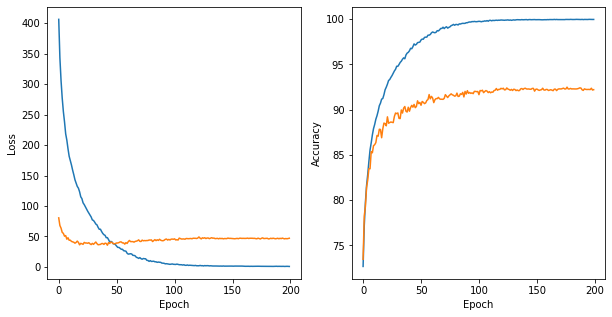

In [17]:
epochs = np.arange(0,200)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1) 
plt.xlabel('Epoch')
plt.ylabel('Loss') 
plt.plot(epochs,loss_list_train) 
plt.plot(epochs,loss_list_test)
plt.subplot(1,2,2) 
plt.xlabel('Epoch') 
plt.ylabel('Accuracy') 
plt.plot(epochs, accuracy_list_train) 
plt.plot(epochs, accuracy_list_test) 
plt.show()